In [1]:
import pandas as pd
import numpy as np
import glob
import os
import tensorflow as tf   
from sklearn.preprocessing import scale
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [2]:
tf.__version__

'2.0.1'

In [3]:
tf.test.is_gpu_available()

True

In [37]:
datas = glob.glob('transfer_gps/*/*/*.txt')
train_data = []
train_label = []
for data in datas:
    f = np.loadtxt(data,delimiter=",").copy()
    o = np.argsort(f,axis=(0))[:,3]
    f = f[o]
    f.resize((10,4))
    train_data.append(f/100000000)
    if data.split('/')[1] == "indoor":
        train_label.append("indoor"+data.split('/')[-2])
    else:
        train_label.append("outdoor"+data.split('/')[-2])
        

train_data = np.array(train_data)
#train_data[:,:,0] -= train_data[:,:,0].mean()
#train_data[:,:,0] /= train_data[:,:,0].var()

#train_data[:,:,1] -= train_data[:,:,1].mean()
#train_data[:,:,1] /= train_data[:,:,1].var()
#train_data[:,:,2] -= train_data[:,:,2].mean()
#train_data[:,:,2] /= train_data[:,:,2].var()
#train_data[:,:,3] -= train_data[:,:,3].mean()
train_data[:,:,3] /= 1000000

train_label = pd.get_dummies(train_label).values.argmax(1)
train_label = train_label.reshape(len(train_label),1)

train_val_split = np.random.rand(len(train_data)) < 0.70
train_x = train_data[train_val_split]
train_y = train_label[train_val_split]
val_x = train_data[~train_val_split]
val_y = train_label[~train_val_split]

In [36]:
pd.get_dummies(train_label)

,indoor01,indoor02,indoor03,indoor04,indoor05,indoor06,indoor07,indoor08,indoor09,outdoor01,outdoor02,outdoor03,outdoor04,outdoor05,outdoor06,outdoor07,outdoor08,outdoor09
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4518,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4519,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4520,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4521,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [5]:
train_data[200]

array([[-2.47137134e-02,  1.99958290e-01,  1.70625568e-01,
         2.08821717e-07],
       [-1.20591061e-01,  1.41647518e-01,  1.95820414e-01,
         2.15508339e-07],
       [-1.21782978e-01,  2.25231032e-01, -6.97988411e-02,
         2.18700409e-07],
       [ 1.02166726e-01,  2.45939673e-01, -1.03706659e-02,
         2.37841863e-07],
       [-2.31998314e-03,  2.30737047e-01, -1.31359947e-01,
         2.40439379e-07],
       [ 1.05038078e-01,  1.03898049e-01,  2.20225927e-01,
         2.43750731e-07],
       [-1.44950110e-01, -5.57104541e-02,  2.15002742e-01,
         2.47426486e-07],
       [ 1.65842959e-01,  1.91693144e-01,  8.12978238e-02,
         2.47500367e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [6]:
train_data[:,:,0].mean(),train_data[:,:,0].var(),train_data[:,:,0].max(),train_data[:,:,0].min()

(-0.010454095731284264,
 0.012260868914549135,
 0.2019408379192828,
 -0.26673220239630857)

In [7]:
train_data[:,:,1].mean(),train_data[:,:,1].var(),train_data[:,:,1].max(),train_data[:,:,1].min()

(0.12378203784847644,
 0.010142246237235964,
 0.2459402671140822,
 -0.1686585734740348)

In [8]:
train_data[:,:,2].mean(),train_data[:,:,2].var(),train_data[:,:,2].max(),train_data[:,:,2].min()

(0.020749059895218993,
 0.011775426685903855,
 0.22104323977039841,
 -0.18239073678468307)

In [9]:
train_data[:,:,3].mean(),train_data[:,:,3].var(),train_data[:,:,3].max(),train_data[:,:,3].min()

(0.001208217386795917, 0.000416290117576147, 0.3461716502643769, 0.0)

In [10]:
train_data.mean(),train_data.var()

(0.033821304849801774, 0.011470643398890461)

In [11]:
train_x.shape,train_y.shape,len(val_x)#.shape

((3249, 10, 4), (3249, 1), 1274)

In [12]:
BUFFER_SIZE = 4523
BATCH_SIZE = 5
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_x))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_x)).batch(len(val_x))

In [13]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])
mirrored_strategy

In [14]:
with mirrored_strategy.scope():
    input_o = tf.keras.layers.Input(shape=(4), name='input_layer')
    models = layers.Dense(4, activation='sigmoid')(input_o )
    models = layers.Dense(4, activation='sigmoid')(models)
    models = layers.Dense(4, activation='sigmoid')(models)
    models = layers.Dense(4, activation='sigmoid')(models)
    model = tf.keras.Model(inputs=input_o, outputs=models)
    model.summary()
    input = tf.keras.layers.Input(shape=(10,4), name='input_layer1')
    input1 = layers.Lambda(lambda x: x[:,0,:], output_shape=(1))(input)
    input2 = layers.Lambda(lambda x: x[:,1,:], output_shape=(1))(input)
    input3 = layers.Lambda(lambda x: x[:,2,:], output_shape=(1))(input)
    input4 = layers.Lambda(lambda x: x[:,3,:], output_shape=(1))(input)
    input5 = layers.Lambda(lambda x: x[:,4,:], output_shape=(1))(input)
    input6 = layers.Lambda(lambda x: x[:,5,:], output_shape=(1))(input)
    input7 = layers.Lambda(lambda x: x[:,6,:], output_shape=(1))(input)
    input8 = layers.Lambda(lambda x: x[:,7,:], output_shape=(1))(input)
    input9 = layers.Lambda(lambda x: x[:,8,:], output_shape=(1))(input)
    input10= layers.Lambda(lambda x: x[:,9,:], output_shape=(1))(input)

    model_1 = model(input1)
    model_2 = model(input2)
    model_3 = model(input3)
    model_4 = model(input4)
    model_5 = model(input5)
    model_6 = model(input6)
    model_7 = model(input7)
    model_8 = model(input8)
    model_9 = model(input9)
    model_10= model(input10)
    merge_layer = tf.keras.layers.concatenate(inputs=[model_1, model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10])
    model_encoder = tf.keras.layers.Dense(32, activation='sigmoid')(merge_layer)
    model_encoder = tf.keras.layers.Dense(32, activation='sigmoid')(model_encoder)
    model_encoder = tf.keras.layers.Dense(16, activation='sigmoid')(model_encoder)
    model_down = tf.keras.Model(inputs=[input], outputs=model_encoder,name = "encoder")#input1, input2,input3,input4,input5,input6,input7,input8,input9,input10
    model_down.summary()
    input_encoder = tf.keras.layers.Input(shape=(10,4), name='input_layer2')
    input_decoder = model_down(input_encoder)
    model_decoder = layers.Dense(16, activation='sigmoid')(input_decoder)
    model_decoder = layers.Dense(32, activation='sigmoid')(model_decoder)
    model_decoder = layers.Dense(32, activation='sigmoid')(model_decoder)
    model_decoder = layers.Dense(40, activation='sigmoid')(model_decoder)
    model_decoder = layers.Reshape((10,4))(model_decoder)
    model_encoder_decoder = tf.keras.Model(inputs=[input_encoder],outputs=model_decoder,name = 'encoder_decoder')
    model_encoder_decoder.summary()
    #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=1e-5)
    model_encoder_decoder.compile(optimizer = 'sgd', loss=losses.MeanSquaredError())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)   

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
def decay(epoch):
  if epoch < 300:
    return 1e-2
  elif epoch >= 300 and epoch < 500:
    return 1e-4
  elif epoch >= 500 and epoch < 700:
    return 1e-6
  elif epoch >= 700 and epoch < 900:
    return 1e-8
  else:
    return 1e-10

In [16]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model_encoder_decoder.optimizer.lr.numpy()))

In [17]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [29]:
model_encoder_decoder.fit(train_dataset,
                epochs=1000,
                validation_data=valid_dataset,
                callbacks = callbacks
                         )

Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
    650/Unknown - 18s 28ms/step - loss: 0.0070INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Learning rate for epoch 1 is 0.009999999776482582
650/650 [==============================] - 20s 30ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 2/1000
648/650 [============================>.] - ETA: 0s - loss: 0.0070
Lear

In [19]:
valid_dataset,val_x.shape

(<BatchDataset shapes: ((None, 10, 4), (None, 10, 4)), types: (tf.float64, tf.float64)>,
 (1274, 10, 4))

In [20]:
val_latent = model_down(val_x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

In [21]:
val_latent.shape

TensorShape([1274, 16])

In [22]:
from sklearn import manifold, datasets
import matplotlib.pyplot as plt

In [23]:
train_val_split = np.random.rand(len(val_latent)) < 0.4

In [24]:
X_tsne = manifold.TSNE(n_components=2, init='pca', n_iter=5000, method='exact').fit_transform(val_latent[train_val_split])

In [25]:
X_tsne.shape

(509, 2)

In [26]:
val_latent.shape

TensorShape([1274, 16])

In [27]:
y = val_y[train_val_split]

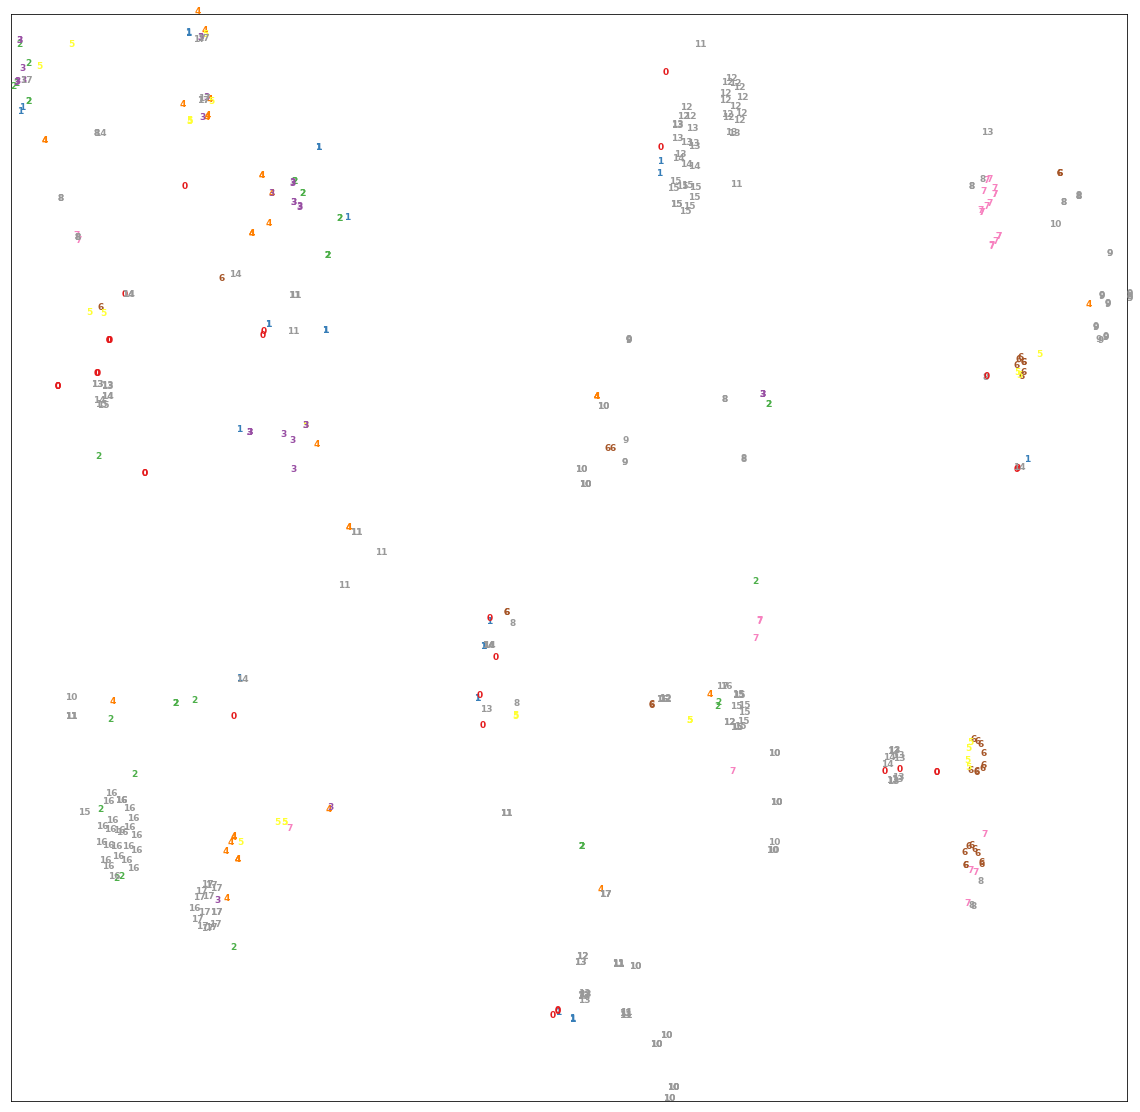

In [28]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(20, 20))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i,0]), color=plt.cm.Set1(y[i,0]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()

In [39]:
plt.savefig("result/pca_result_latent16_XYZ")

<Figure size 432x288 with 0 Axes>

In [ ]:
DNN = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(labels.shape[1], activation='softmax'),
    ])

In [14]:
train_encoded = np.array(autoencoder.encoder(train_x))
val_encoded = np.array(autoencoder.encoder(val_x))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [15]:
DNN.compile(optimizer='adam', loss=losses.CategoricalCrossentropy())

In [17]:
test_encoder = np.array(autoencoder.encoder(test_features))
y_ = DNN(test_encoder)

In [18]:
np.argmax(np.array(y_[2]))

12